# **TikTok (case-study)**

In this notebook, I will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This notebook has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

**Modeling workflow and model selection process:**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)


### **1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

### **2. Examine data, summary info, and descriptive stats**

In [4]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [5]:
# Get number of rows and columns
print(f"Data Shape: {data.shape}")

Data Shape: (19084, 12)


In [6]:
# Get data types of columns
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

In [7]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.7+ MB


Generate basic descriptive statistics about the dataset.

In [8]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5509.220604,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19084.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle outliers.

In [9]:
# Iterates over the column names of each count variable to get the number of outliers in them
numeric_cols = [
        "video_duration_sec", 
        "video_view_count", 
        "video_like_count", 
        "video_share_count", 
        "video_download_count", 
        "video_comment_count"
]
for col in numeric_cols:
    iqr = data[col].quantile(0.75) - data[col].quantile(0.25)
    median = data[col].median()
    print("Number of outliers in {0} = {1}".format(col, (data[col] > median + 1.5 * iqr).sum()))

Number of outliers in video_duration_sec = 0
Number of outliers in video_view_count = 2343
Number of outliers in video_like_count = 3468
Number of outliers in video_share_count = 3732
Number of outliers in video_download_count = 3733
Number of outliers in video_comment_count = 3882


Check class balance.

In [10]:
# Check class balance
str_cols = [
        "claim_status",
        "verified_status",
        "author_ban_status",
]
for col in str_cols:
    print(f"Classes counts in:\n")
    print(f"{data[col].value_counts(normalize=True)}\n\n")

Classes counts in:

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64


Classes counts in:

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64


Classes counts in:

author_ban_status
active          0.806068
under review    0.108258
banned          0.085674
Name: proportion, dtype: float64




### **3. Feature engineering**

In [11]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [12]:
# Calculate the average text_length for claims and opinions
print("Average text length for claims and opinions")
data[['claim_status', 'text_length']].groupby('claim_status').mean()

Average text length for claims and opinions


,text_length
claim_status,
claim,95.376978
opinion,82.722562


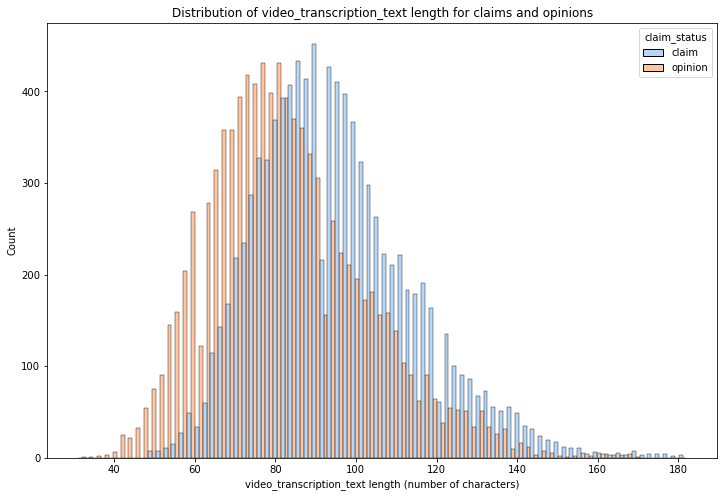

In [13]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

In [14]:
# Create a copy of the X data
X = data.copy()

# Drop unnecessary columns
X.drop(["#", "video_id"], axis=1)

# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                  columns=['verified_status', 'author_ban_status'],
                  drop_first=True
                  )

### **4. Split the data**

In [15]:
# Isolate target variable
y = X['claim_status']

In [16]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,#,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,2,4014381136,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,3,9859838091,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,4,1866847991,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,5,7105231098,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **5. Create train/validate/test sets**

In [17]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [18]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [19]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 13), (3817, 13), (3817, 13), (11450,), (3817,), (3817,))

### **Tokenize text column**


In [20]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [21]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing wager
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,...,internet forum,learned internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing wager
0,2000,1426146810,44,391174.0,23682.0,2474.0,81.0,20.0,99,False,...,0,0,0,0,0,0,0,0,0,0
1,6638,3750143866,51,641702.0,142825.0,32011.0,2158.0,729.0,136,False,...,0,0,0,0,0,0,0,0,0,0
2,17871,9335579628,11,8774.0,463.0,144.0,8.0,3.0,117,False,...,0,0,0,0,0,0,0,0,0,0
3,12658,7641270825,44,5963.0,1279.0,60.0,25.0,1.0,74,False,...,0,0,0,0,0,0,0,0,0,0
4,268,2188868783,49,883273.0,169172.0,39076.0,311.0,66.0,135,False,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,...,internet forum,learned internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing wager
0,9331,8878467854,5,164241.0,32994.0,1131.0,524.0,18.0,101,False,...,0,0,0,0,0,0,0,0,0,0
1,14321,7542213796,36,6570.0,2436.0,87.0,4.0,1.0,82,False,...,0,0,0,0,0,0,0,0,0,0
2,4082,6033731994,33,800913.0,455281.0,125753.0,8559.0,227.0,102,False,...,0,0,0,0,0,0,0,0,0,0
3,2032,7949762137,39,381930.0,183608.0,17052.0,3182.0,889.0,79,False,...,0,0,0,0,0,0,0,0,0,0
4,15688,5952927647,36,2693.0,407.0,68.0,4.0,1.0,80,False,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,...,internet forum,learned internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing wager
0,18921,9423112256,22,6517.0,337.0,120.0,5.0,0.0,73,False,...,0,0,0,0,0,0,0,0,0,0
1,6934,8822399578,39,758131.0,41367.0,11288.0,774.0,143.0,83,False,...,0,0,0,0,0,0,0,0,1,0
2,352,9713031749,17,613559.0,368043.0,113662.0,7130.0,4288.0,76,False,...,0,0,0,0,0,0,0,0,0,0
3,8942,7073857759,9,363966.0,196481.0,1246.0,1593.0,657.0,114,False,...,0,0,0,0,0,0,0,0,0,0
4,386,3158722505,5,582955.0,86748.0,7182.0,865.0,21.0,98,False,...,0,0,0,0,0,0,0,0,0,0


### **6. Build models**

### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [28]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [29]:
# %%time
rf_cv.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'recall', 'accuracy', 'f1'})

In [30]:
import pickle 

# Define a path to the folder where you want to save the model
path = ''

In [31]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [32]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [33]:
model_name = 'rf_model'
# Save a pre-trained model
write_pickle(path, rf_cv.best_estimator_, model_name)
# Read a pre-trained model
# rf_cv = read_pickle(path, model_nameme)

In [34]:
# Examine best recall score
rf_cv.best_score_

1.0

In [35]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.3,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

### **Build an XGBoost model**

In [36]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)


# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [37]:
# %%time
xgb_cv.fit(X_train_final, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

In [38]:
model_name = 'xgb_model'
# Save a pre-trained model
write_pickle(path, xgb_cv.best_estimator_, model_name)
# Read a pre-trained model
# xgb_cv = read_pickle(path, model_name)

In [39]:
xgb_cv.best_score_

1.0

In [40]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

### **7. Evaluate model**

#### **Random forest**

In [41]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

Display the predictions on the encoded testing set.

In [42]:
# Display the predictions on the encoded testing set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

Display the true labels of the testing set.

In [43]:
# Display the true labels of the testing set
y_val

9330     1
14320    0
4081     1
2031     1
15687    0
        ..
6056     1
3819     1
6857     1
5261     1
9152     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

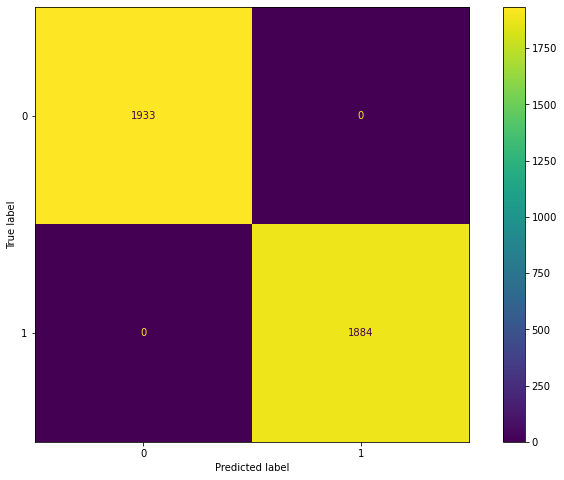

In [44]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [45]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1933
       claim       1.00      1.00      1.00      1884

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Question:** What does your classification report show? What does the confusion matrix indicate?

#### **XGBoost**

In [46]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

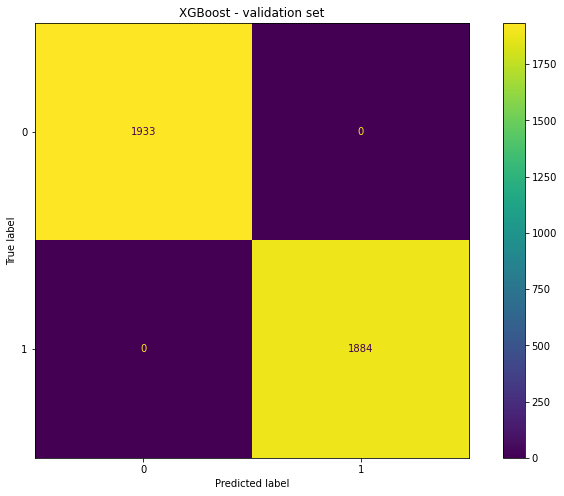

In [47]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [48]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1933
       claim       1.00      1.00      1.00      1884

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

### **Use champion model to predict on test data**

In [49]:
y_pred = rf_cv.best_estimator_.predict(X_test_final)

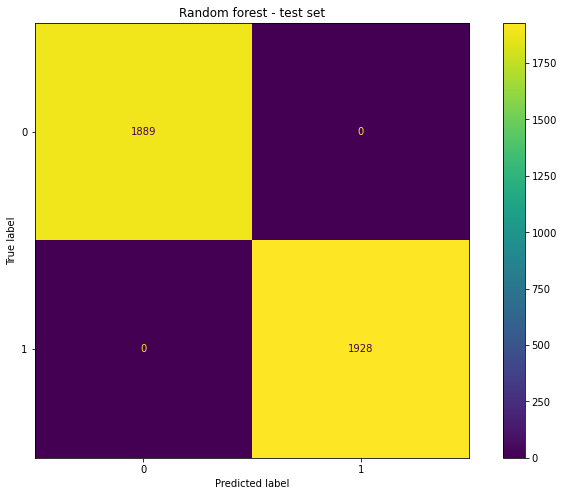

In [50]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**


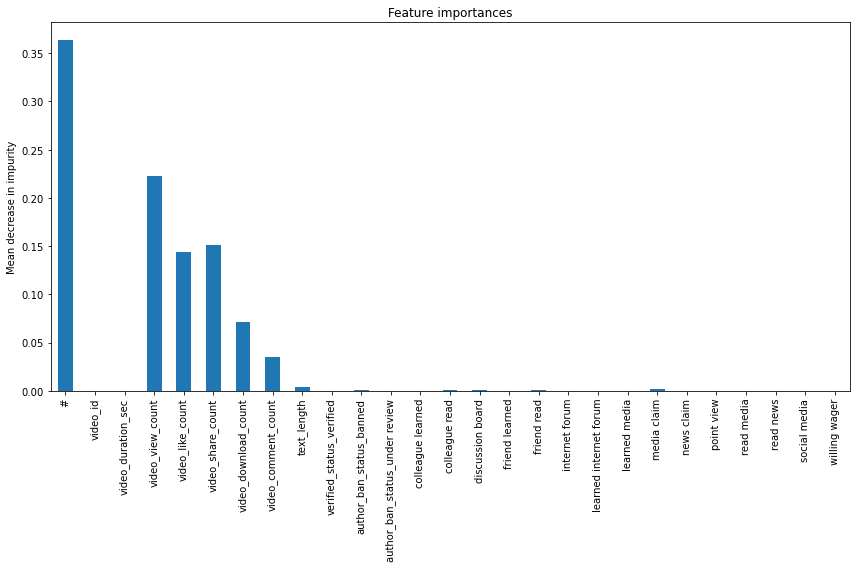

In [51]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()